In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy


In [2]:
# read in data
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


In [3]:
def consolidate_date(outlooks, pph, reports):
    earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
    latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))
    reports = reports[reports['DATE'] <= latest_date]
    reports = reports[reports['DATE'] >= earliest_date]
    outlooks = outlooks[outlooks['DATE'] <= latest_date]
    outlooks = outlooks[outlooks['DATE'] >= earliest_date]
    all_pph_dates = pph['time']
    pph_dates = all_pph_dates[all_pph_dates <= latest_date]
    pph_dates = pph_dates[pph_dates >= earliest_date]
    pph = pph.sel(time = pph_dates)
    return(outlooks, pph, reports)

(outlooks, pph, reports) = consolidate_date(outlooks, pph, reports)


In [4]:
label_names = ['MAX_CAT', 'RAMP_CATEGORIES', 'SEASON', 'REGION', 'RAMP_UP', 'RAMP_DOWN']

category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}

ramp_dict = {
    'up': 0,
    'down': 1,
    'both': 2,
    'neither': 3
}

season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Grea': 1,
    'Midw': 2,
    'Nort': 3,
    'Sout': 4
}

ramp_up_dict = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6
}

ramp_down_dict = {
    '0': 0,
    '-1': 1,
    '-2': 2,
    '-3': 3,
    '-4': 4,
    '-5': 5,
    '-6': 6
}

dicts = [category_dict, ramp_dict, season_dict, region_dict, ramp_up_dict, ramp_down_dict]
written_labels = ['Categorical Risk', 'Ramp', 'Season', 'Region', 'Ramp Up', 'Ramp Down']


In [20]:
def plot_distribution(pph, label_name, label_dict, written_label, titlestring, save_location, show=False):
    labels = pph[label_name]
    label_counts = labels.groupby(labels).count()
    def sort_order(key):
        return label_dict[str(key[0])]
    sorted_labels, sorted_counts = zip(*sorted(zip(list(label_counts[label_name].values), label_counts.values), key = sort_order))
    plt.bar(sorted_labels, sorted_counts)  
    plt.xlabel(written_label)
    plt.title('Number of ' + titlestring + ' Days With Each '  + written_label)
    plt.ylabel("Number of Days")
    plt.savefig(save_location + '/' + written_label + '_distribution.png')
    if show:
        plt.show()
    plt.close()

In [6]:
def plot_distribution_2d(pph, label_1, label_2, label_1_string, label_2_string, dict_1, dict_2, titlestring, save_location, show=False):
# plot 2d heatmap for any 2 labels
    data1 = []
    data2 = []

    for i in range(len(pph[label_1])):
        data1.append(dict_1[str(pph[label_1].values[i])])
        data2.append(dict_2[str(pph[label_2].values[i])])

    max1 = max(dict_1.values())
    min1 = min(dict_1.values())

    max2 = max(dict_2.values())
    min2 = min(dict_2.values())

    bins1 = np.linspace(min1-.5, max1+.5, 2+max1-min1)
    bins2 = np.linspace(min2-.5, max2+.5, 2+max2-min2)

    heatmap = np.histogram2d(data1, data2, bins = (bins1, bins2))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)
    for i in range(bins1.size-1): 
        for j in range(bins2.size-1): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    plt.yticks(range(len(list(dict_1.values()))), labels=list(dict_1.keys()))
    plt.xticks(range(len(list(dict_2.values()))), labels=list(dict_2.keys()))
    plt.ylabel(label_1_string)
    plt.xlabel(label_2_string)
    plt.title("Number of " + titlestring + " Days with each Combination of " + label_1_string + " and " +  label_2_string)
    plt.savefig(save_location + '/' + label_1_string + '_' + label_2_string + '_distribution.png')
    if show:
        plt.show()
    plt.close()

In [25]:
# THIS NEEDED TO BE RERUN TWICE FOR SOME REASON

# moderate and up days only:
all_pph_dates = pph['time']
mdt_pph_dates = all_pph_dates[pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_pph = pph.sel(time = mdt_pph_dates)

# dates since new categorical system 
new_cutoff = '201410230000'
new_pph_dates = all_pph_dates[all_pph_dates >= new_cutoff]
new_pph = pph.sel(time = new_pph_dates)

# Moderate dates in new system
mdt_new_pph_dates = mdt_pph_dates[mdt_pph_dates >= new_cutoff]
mdt_new_pph = pph.sel(time = mdt_new_pph_dates)

In [8]:
def make_plots(pph, label_names, dicts, written_labels, shortstring, titlestring, show=False):
    for i in range(len(written_labels)):
        plot_distribution(pph, label_names[i], dicts[i], written_labels[i], titlestring, 'plots/label_distributions/'+ shortstring+'/1d/', show=show)

    for i in range(len(label_names)):
        for j in range(i):
            plot_distribution_2d(pph, label_names[i], label_names[j], written_labels[i], written_labels[j], dicts[i], dicts[j], titlestring, 'plots/label_distributions/'+ shortstring+'/2d/', show=show)

In [32]:
make_plots(pph, label_names, dicts, written_labels, 'all', 'All')
make_plots(mdt_pph, label_names, dicts, written_labels, 'mdt', 'Moderate')
make_plots(new_pph, label_names, dicts, written_labels, 'new', 'New')
make_plots(mdt_new_pph, label_names, dicts, written_labels, 'mdt_new', 'Moderate New')


<xarray.DataArray 'MAX_CAT' (time: 13141)>
array(['NONE', 'NONE', 'NONE', ..., 'MRGL', 'MRGL', 'MRGL'], dtype=object)
Coordinates:
  * time     (time) object '198701090000' '198701100000' ... '202212310000'
DataArrayGroupBy, grouped over 'MAX_CAT'
7 groups with labels 'ENH', 'HIGH', ..., 'SLGT', 'TSTM'.
a
<xarray.DataArray 'RAMP_CATEGORIES' (time: 13141)>
array(['neither', 'neither', 'neither', ..., 'neither', 'up', 'up'],
      dtype=object)
Coordinates:
  * time     (time) object '198701090000' '198701100000' ... '202212310000'
DataArrayGroupBy, grouped over 'RAMP_CATEGORIES'
4 groups with labels 'both', 'down', 'neither', 'up'.
a
<xarray.DataArray 'SEASON' (time: 13141)>
array(['Winter', 'Winter', 'Winter', ..., 'Winter', 'Winter', 'Winter'],
      dtype=object)
Coordinates:
  * time     (time) object '198701090000' '198701100000' ... '202212310000'
DataArrayGroupBy, grouped over 'SEASON'
4 groups with labels 'Fall', 'Spring', ..., 'Winter'.
a
<xarray.DataArray 'REGION' (time: 13141

Investigate: old ramp ups by 5? Why lots of 5 and not 4? And none region, make sure no PPH.

In [52]:
test_outlooks = outlooks[outlooks['RAMP_UP'] == 5]
test_outlooks

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,DATE,MAX_CAT,DATE_ORDER,RAMP_UP,RAMP_DOWN,RAMP_CATEG,SEASON,REGION,geometry
10160,199504091200,199504101200,199504080721,C,2,None,None,7,199504090000,MDT,1995040900002,5,0,up,Spring,Great Plains,None
10161,199504091200,199504101200,199504081808,C,2,MDT,CATEGORICAL,17,199504090000,MDT,1995040900003,5,0,up,Spring,Great Plains,"LINESTRING (-97.60000 35.40000, -97.10000 36.7..."
10162,199504091200,199504101200,199504081808,C,2,SLGT,CATEGORICAL,17,199504090000,MDT,1995040900003,5,0,up,Spring,Great Plains,"LINESTRING (-100.61000 30.52000, -100.23000 32..."
10163,199504091200,199504101200,199504090608,C,1,SLGT,CATEGORICAL,6,199504090000,MDT,1995040900004,5,0,up,Spring,Great Plains,"LINESTRING (-98.50000 33.97000, -98.97000 36.9..."
10164,199504091200,199504101200,199504090608,C,1,TSTM,CATEGORICAL,6,199504090000,MDT,1995040900004,5,0,up,Spring,Great Plains,"LINESTRING (-95.07800 49.36000, -95.02600 49.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41494,201209081200,201209091200,201209071727,C,2,SLGT,CATEGORICAL,17,201209080000,MDT,2012090800003,5,0,up,Fall,Northeast,"LINESTRING (-79.95006 42.45379, -79.77700 42.5..."
41495,201209081200,201209091200,201209071727,C,2,TSTM,CATEGORICAL,17,201209080000,MDT,2012090800003,5,0,up,Fall,Northeast,"MULTILINESTRING ((-82.43320 44.89330, -82.4310..."
41496,201209081200,201209091200,201209080527,C,1,SLGT,CATEGORICAL,6,201209080000,MDT,2012090800004,5,0,up,Fall,Northeast,"LINESTRING (-78.38800 43.63900, -77.88700 43.6..."
41497,201209081200,201209091200,201209080527,C,1,MDT,CATEGORICAL,6,201209080000,MDT,2012090800004,5,0,up,Fall,Northeast,"LINESTRING (-73.63337 40.25580, -73.63500 40.2..."


In [31]:
new_pph

<xarray.Dataset>
Dimensions:             (time: 2992, x: 93, y: 65)
Coordinates:
  * time                (time) object '201410230000' ... '202212310000'
  * x                   (x) float64 0.0 1.0 2.0 3.0 4.0 ... 89.0 90.0 91.0 92.0
  * y                   (y) float64 0.0 1.0 2.0 3.0 4.0 ... 61.0 62.0 63.0 64.0
Data variables: (12/15)
    lat                 (y, x) float64 ...
    lon                 (y, x) float64 ...
    p_perfect_wind      (time, y, x) float64 ...
    p_perfect_sig_wind  (time, y, x) float64 ...
    p_perfect_hail      (time, y, x) float64 ...
    p_perfect_sig_hail  (time, y, x) float64 ...
    ...                  ...
    RAMP_UP             (time) int32 0 0 1 0 1 1 0 0 0 0 ... 0 0 0 0 1 0 0 0 1 1
    RAMP_DOWN           (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    RAMP_CATEGORIES     (time) object 'neither' 'neither' 'up' ... 'up' 'up'
    SEASON              (time) object 'Fall' 'Fall' 'Fall' ... 'Winter' 'Winter'
    p_perfect_total     (time, y, x) float64 ...
    REGION              (time) object 'West' 'West' 'Nort' ... 'Sout' 'NONE'
Attributes:
    title:         Practically Perfect Wind Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

plotting outlooks


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


plotting pph


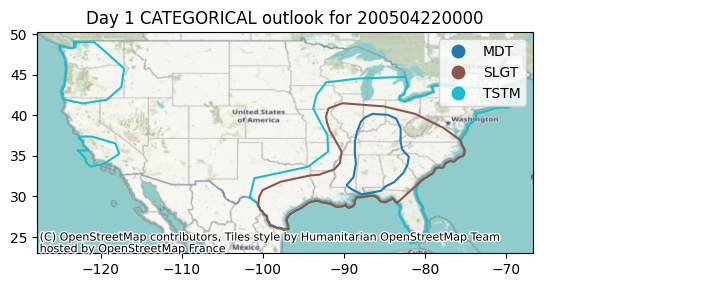

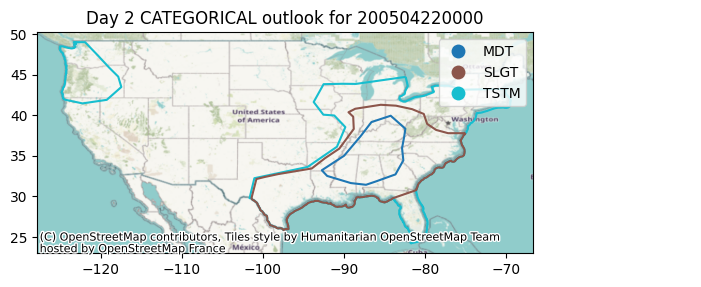

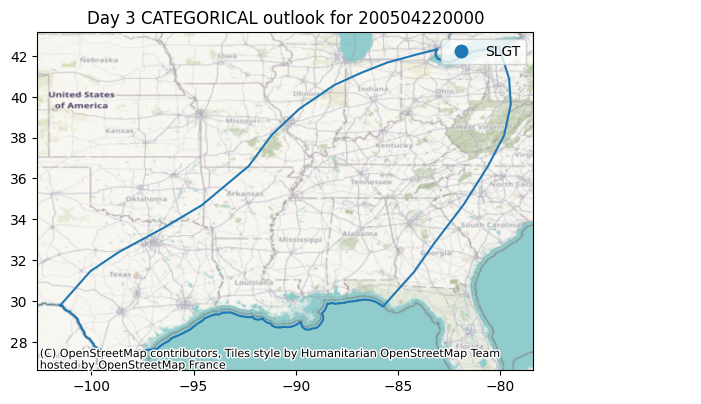

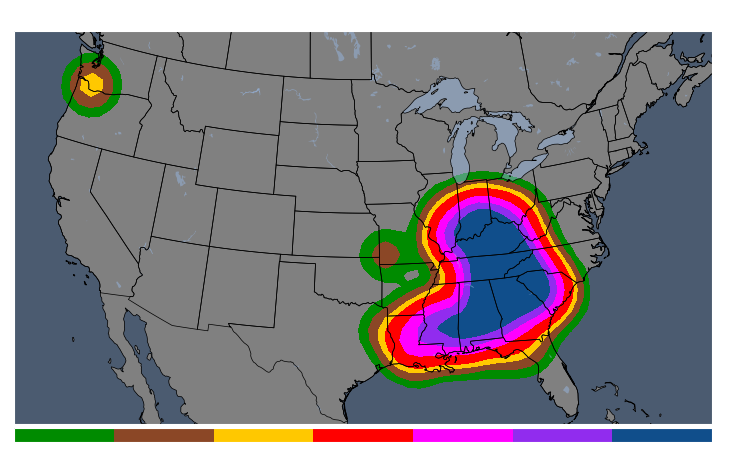

In [48]:
# TODO: make function that plots all 3 outlooks, PPH, and reports for one day to spotcheck
# with utils_plotting functions
def plot_day(datestring, outlooks, pph, reports):
    outlooks_day = outlooks[outlooks['DATE'] == datestring]
    pph_day = pph.sel(time=datestring)
    reports_day = reports[reports['DATE'] == datestring]
    
    print('plotting outlooks')
    plot_outlooks_day(outlooks_day, 'plots/daily/'+datestring+'/outlooks', ['CATEGORICAL'], show=True)
    print('plotting pph')
    plot_pph_day(pph_day, 'plots/daily/'+datestring+'/pph', ['total'], show=True, sig = False)
    #print('plotting reports')
    #plot_reports(reports_day, 'plots/daily/'+datestring+'/reports', ['Hail', 'Thunderstorm Wind', 'Tornado'], show=True)
    return

plot_day('200504220000', outlooks, pph, reports)

plotting outlooks


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


plotting pph


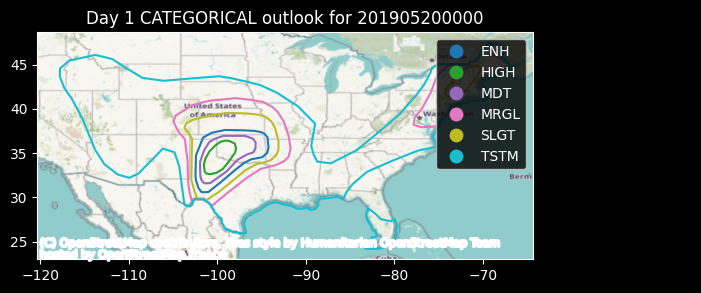

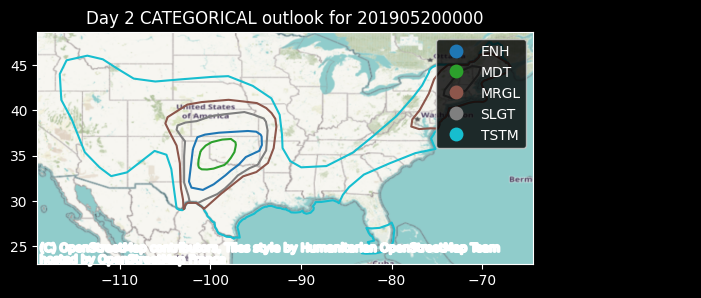

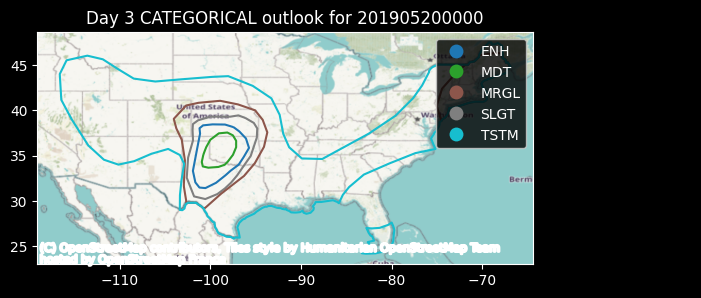

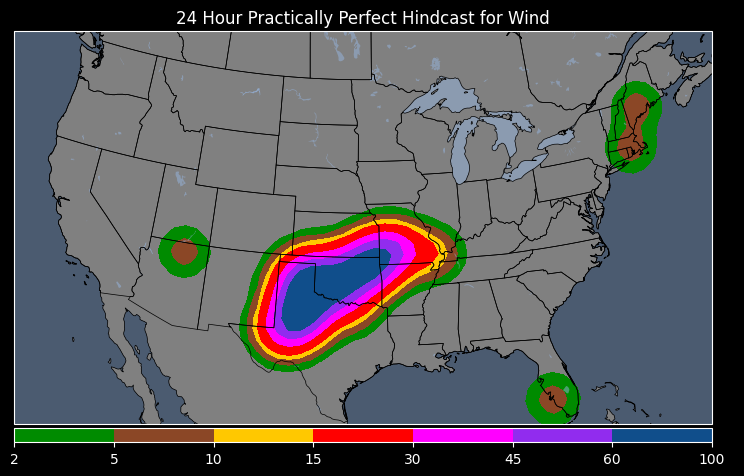

In [50]:

plot_day('201905200000', outlooks, pph, reports)

# OLD NON-GENERALIZED PLOTTING OF RAMPS / SCRATCH WORK

In [ ]:
def plot_ramps(pph, title_insert=''):
    # 2d histogram of ramps
    # NOT FOR USE
    ramp_up_bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    ramp_up_amounts = [0, 1, 2, 3, 4, 5, 6]
    ramp_down_amounts = [-6, -5, -4, -3, -2, -1, 0]
    ramp_down_bins = [-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -.5, .5]
    heatmap = np.histogram2d(np.array(pph['RAMP_UP'][pph['RAMP_UP']!= 'NONE'], dtype=int), np.array(pph['RAMP_DOWN'][pph['RAMP_UP']!= 'NONE'], dtype=int), bins = (ramp_up_bins, ramp_down_bins))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)
    bins = len(ramp_up_bins)
    for i in range(bins-1): 
        for j in range(bins-1): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    plt.xticks(ramp_up_amounts, labels=ramp_down_amounts)
    plt.yticks(ramp_up_amounts, labels=ramp_up_amounts)
    plt.xlabel("Ramp Down")
    plt.ylabel("Ramp Up")
    plt.title("Number of " + title_insert + "Days with each Ramp Up and Ramp Down Amount")
    plt.show()

In [47]:
str(mdt_pph['time'].values).replace('\n ', ' ').replace(' ', ', ')

"['198704130000', '198705020000', '198705030000', '198705190000', '198705210000', '198706010000', '198706170000', '198706180000', '198706190000', '198706240000', '198707110000', '198707120000', '198708160000', '198709140000', '198711160000', '198712140000', '198801190000', '198803020000', '198803240000', '198803280000', '198804060000', '198804170000', '198804230000', '198805070000', '198805080000', '198805090000', '198806030000', '198806090000', '198807170000', '198808120000', '198808200000', '198808210000', '198809280000', '198811040000', '198811190000', '198811250000', '198811260000', '198812270000', '198902200000', '198903040000', '198903050000', '198903140000', '198903270000', '198903280000', '198903290000', '198903310000', '198904030000', '198904270000', '198905040000', '198905080000', '198905090000', '198905120000', '198905140000', '198905150000', '198905160000', '198905170000', '198905180000', '198905210000', '198905220000', '198905230000', '198905240000', '198906010000', '19890

In [ ]:
mdt_new_pph['time'].where(mdt_new_pph['MAX_CAT'] == 'HIGH')